# CIFAR10 전이학습 기반 분류기


이 노트북은 사전 훈련된 심층-CNN 중에서 VGG16으로 전이학습의 개념을 확용한 분류기를 구축하는 단계를 개략적으로 설명한다.


In [1]:
%matplotlib inline

In [2]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit 임포트
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils

# Matplot 임포트
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

# 판다스는 데이터 프레임을 테이블로 보여준다.

from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import np_utils

## 데이터 세트 로딩과 준비

In [4]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Split training dataset in train and validation sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [7]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

### 전처리

VGG16을 특성 추출기로 사용할 것이기 때문에, 이미지의 최소 크기는 48x48이어야 한다. ```scipy```로 이미지 크기를 필요한 차원으로 재조정 한다.

In [8]:
X_train = np.array([sp.misc.imresize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([sp.misc.imresize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([sp.misc.imresize(x, 
                                    (48, 48)) for x in X_test])

## 모델 준비

* 최상위층 없이 VGG16 로딩
* 커스텀 분류기 준비
* 모델의 맨 위에 새로운 층 쌓기

In [9]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


목표는 분류층만 훈련시키는 것이기 때문에 훈련할 수 있는 파라미터 세팅을 False로 해서 나머지 층을 동결했다. 이렇게 하면 덜 강력한 기반 구조에서도 기존 아키텍처를 활용할 수 있고 학습된 가중치를 한 도메인에서 다른 도메인으로 전이할 수 있다.

In [10]:
# VGG16 모델의 세 번째 블록에서 마지막 층 추출
last = base_model.get_layer('block3_pool').output

In [11]:
# 상위 층에 분류층 추가
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

우리의 목표는 커스컴 분류기를 훈련시키는 것이기 때문에 VGG16 층은 동결한다.

In [12]:
for layer in base_model.layers:
     layer.trainable = False

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

## 데이터 늘리기

소규모 데이터 세트의 한계를 극복하고 모델을 일반화할 수 있도록 ```케라스``` 유틸리티로 데이터 세트를 늘려준다.

In [15]:
# 데이터 늘리기 구성의 준비
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [16]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [17]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## 모델 훈련

이제 모델을 몇 번의 에포크로 훈련시키고 그 성능을 측정해 보자. 다음 코드로 모델에 새로 추가된 층을 훈련시키기 위한 fit_generator() 함수를 호출한다.

In [18]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1328/1328 [==============================] - 30s 23ms/step - loss: 0.2499 - acc: 0.9097 - val_loss: 0.1887 - val_acc: 0.9271
Epoch 2/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1969 - acc: 0.9245 - val_loss: 0.1639 - val_acc: 0.9367
Epoch 3/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1783 - acc: 0.9315 - val_loss: 0.1522 - val_acc: 0.9404
Epoch 4/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1674 - acc: 0.9354 - val_loss: 0.1451 - val_acc: 0.9436
Epoch 5/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1600 - acc: 0.9379 - val_loss: 0.1393 - val_acc: 0.9457
Epoch 6/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1538 - acc: 0.9399 - val_loss: 0.1354 - val_acc: 0.9472
Epoch 7/40
1328/1328 [==============================] - 30s 22ms/step - loss: 0.1487 - acc

1328/1328 [==============================] - 27s 20ms/step - loss: 0.1036 - acc: 0.9600 - val_loss: 0.1112 - val_acc: 0.9564
Epoch 36/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1029 - acc: 0.9603 - val_loss: 0.1111 - val_acc: 0.9556
Epoch 37/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1019 - acc: 0.9609 - val_loss: 0.1113 - val_acc: 0.9562
Epoch 38/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.0999 - acc: 0.9612 - val_loss: 0.1111 - val_acc: 0.9564
Epoch 39/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.0990 - acc: 0.9617 - val_loss: 0.1105 - val_acc: 0.9563
Epoch 40/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.0990 - acc: 0.9615 - val_loss: 0.1109 - val_acc: 0.9563


## 모델 성능 분석

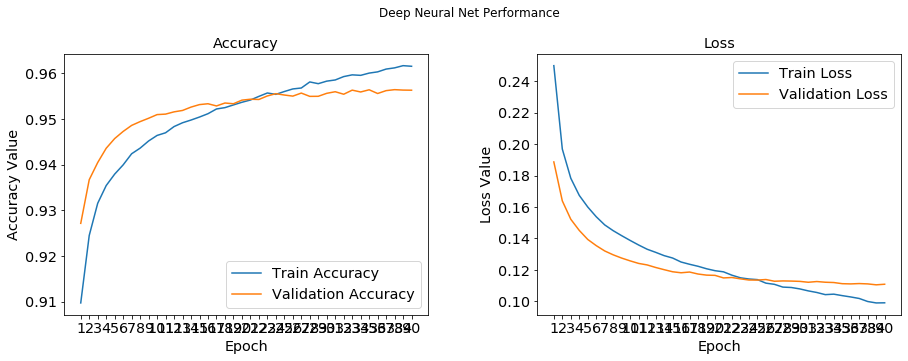

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
predictions = model.predict(X_test/255.)

In [21]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [22]:
import model_evaluation_utils as meu

In [24]:
meu.get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.7649
Precision: 0.7641
Recall: 0.7649
F1 Score: 0.7639


## 예측 시각화

In [25]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

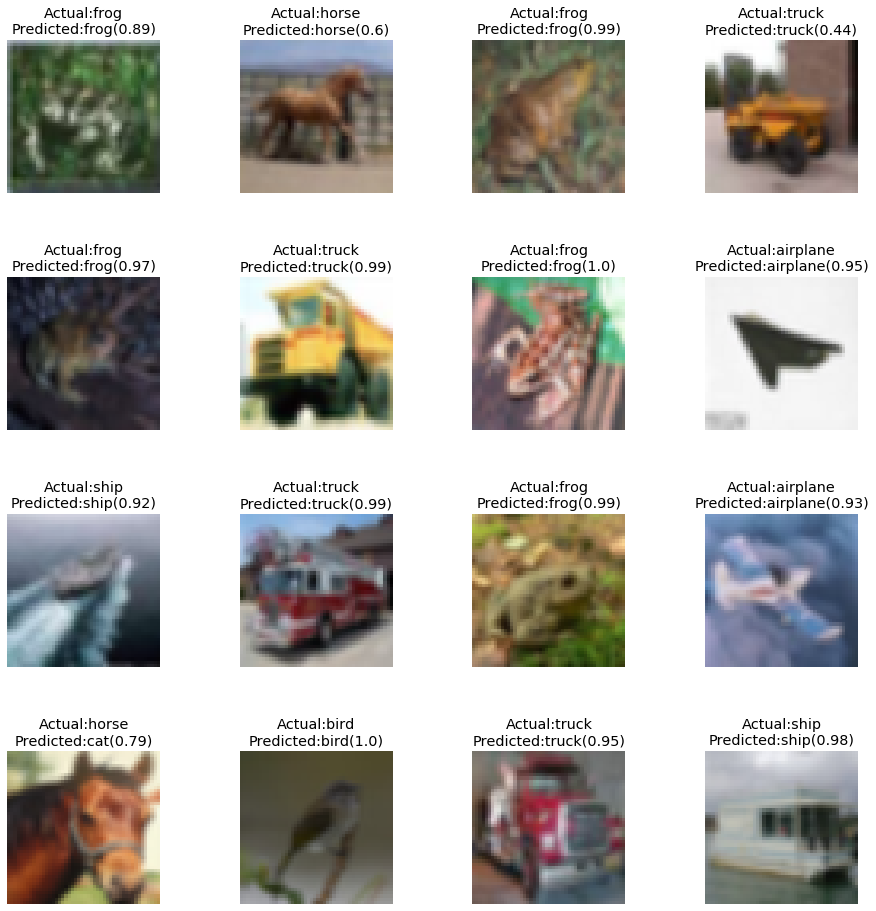

In [26]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)